<a id='summary'></a>
# Spatialization
* Total time ~00:10:00
* Using the Orange OD Matrix as a transition matrix to draw destinations for the census equipped with agendas.

## Summary
* [Loading data](#data)
    * [GIS](#gis)
    * [synthetic pop](#synthpop)
    * [transition_matrices](#od)
    * [transition_matrices by mode](#od_mode)
   
   
* [Utilitary functions](#util_trans)


* [Drawing](#drawing)
    * [v1](#v1)
    * [v2](#v2)
    * [v3](#v3)
    * [v4](#v4)
    * [v4.5](#v4.5)
    * [v5](#v5)


In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import contextily as ctx
import geopandas as gpd
from tqdm import tqdm

from utils.chrono import Chrono


with open('config.json', 'r') as config_path:
    config = json.load(config_path)
    


#transition_matrix_path = '/Users/benoit/Desktop/Pro/210526-fusion/outdata/iris_Mod_unanon.csv'
#transition_matrix_mode_path = '/Users/benoit/Desktop/Pro/210526-fusion/outdata/trans_matrix_by_mode.csv'

<a id='data'></a>
# Loading data

<a id='gis'></a>
## Loading GIS
* Just to get the nearest neighbours for when agents ask for flows that do not exist in the transition matrix
* [back to summary](#summary)

In [4]:
gis_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['gis_map_filename'])
iris_commune = gpd.read_file(gis_path)
iris_commune = iris_commune.drop(columns=['wkt','geometry', 'is_iris'])

iris_commune['iris_or_commune'] = iris_commune['iris_or_commune'].astype(int)
for col in iris_commune.columns:
    if 'nearest_neighbor_' in col:  
        iris_commune[col] = iris_commune[col].astype(int)

iris_commune.head()


,iris_or_commune,frac_area,commune,x,y,nearest_neighbor_0,nearest_neighbor_1,nearest_neighbor_2,nearest_neighbor_3,nearest_neighbor_4,...,nearest_neighbor_10,nearest_neighbor_11,nearest_neighbor_12,nearest_neighbor_13,nearest_neighbor_14,nearest_neighbor_15,nearest_neighbor_16,nearest_neighbor_17,nearest_neighbor_18,nearest_neighbor_19
0,1043,1.0,01043,3932172.925186967,2538222.734103135,692820201,692820103,692560101,692860101,692820203,...,1275,692790101,692820601,1249,1276,1424,1262,1418,1049,1376
1,1049,0.903,01049,3934407.726084904,2538725.650855867,692820103,692820201,1275,692750111,692820204,...,692820101,1249,692820601,692790101,1424,1376,1418,1276,1043,1262
2,1249,0.901,01249,3927976.9199368283,2538778.845483301,692860102,69292,692860501,692860201,69033,...,69293,692860502,692860302,1043,692860303,692860304,1424,692860101,1376,1275
3,1262,0.161,01262,3934403.885727907,2540983.4562672246,692820201,692820204,692820104,692860101,692750111,...,692820101,692820601,692790101,1249,1418,1276,1376,1424,1043,1049
4,1275,1.0,01275,3926871.854005055,2536284.03097829,692560202,1376,692860501,692560302,692560301,...,692860202,692860502,1249,692860401,692860301,692560101,692860302,692860101,692860304,692860303


<a id='synthpop'></a>
## Loading synthetic population
* [back to summary](#summary)

In [6]:
synthpop_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['synthpop_rescaled_filename'])
c=Chrono('Loading agents from {}'.format(synthpop_path))
synthpop = pd.read_csv(synthpop_path)
c.tprint('{} rows, 1 agents per row'.format(len(synthpop)))

max_chain_len = synthpop['chain_len'].max()
c.tprint('max_chain_len = {}'.format(max_chain_len))

c.tprint('Creating columns to store spatialisation...')
for i in range(1, max_chain_len+1):
    synthpop['dep_{}_zone'.format(i)] = np.nan
synthpop['dep_0_zone'] = synthpop['iris_or_commune']
c.done()


15:55:44	Loading agents from /Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/synthpop_statmatch_rescaleipu.csv
00:00:11	1325939 rows, 1 agents per row
00:00:11	max_chain_len = 10
00:00:11	Creating columns to store spatialisation...
00:00:11	Work complete !


<a id='od'></a>
## Transition matrices
* [back to summary](#summary)

In [8]:
transition_matrix_path = os.path.join(config['outdata_dir']['path'],
                                      config['outdata_dir']['transition_matrix_unanon_filename'])

c = Chrono('Loading...')
transition_matrix = pd.read_csv(transition_matrix_path)
timesteps = transition_matrix['t'].unique()


c.write('Parsing into dict...')
d_list_dict = {}
proba_d_dict = {}

for o in tqdm(transition_matrix['o'].unique()):
    trans_matrix_sub_o = transition_matrix[transition_matrix['o']==o]
    for t in timesteps:
        trans_matrix_sub = trans_matrix_sub_o[trans_matrix_sub_o['t']==t]

        k = (o,t)
        trans_matrix_sub = trans_matrix_sub.sort_values('d')
        
        d_list_dict[k] = trans_matrix_sub['d'].values
        proba_d_dict[k] = trans_matrix_sub['proba_d'].values

c.done()


15:57:48	Loading...
00:00:01	To dict...


100%|█████████████████████████████████████████| 536/536 [00:07<00:00, 76.34it/s]

00:00:08	Work complete !


<a id='od_mode'></a>
## Transition matrices by mode
* Used starting from v4
* [back to summary](#summary)

In [9]:
transition_matrix_mode_path = os.path.join(config['outdata_dir']['path'],
                                      config['outdata_dir']['transition_matrix_by_mode'])

c=Chrono('Loading transition matrix by mode...')
trans_matrix_mode = pd.read_csv(transition_matrix_mode_path)

c.write('Parsing into dict...')
mode_d_list_dict = {}
mode_proba_d_dict = {}

for o in tqdm(trans_matrix_mode['o'].unique()):
    trans_matrix_sub_o = trans_matrix_mode[trans_matrix_mode['o']==o]
    for t in timesteps:
        trans_matrix_sub_ot = trans_matrix_sub_o[trans_matrix_sub_o['t']==t]
        for m in range(4):
            trans_matrix_sub = trans_matrix_sub_ot[trans_matrix_sub_ot['mode']==m]

            k = (o,t,m)
            trans_matrix_sub = trans_matrix_sub.sort_values('d')
            
            mode_d_list_dict[k] = trans_matrix_sub['d'].values
            mode_proba_d_dict[k] = trans_matrix_sub['proba_d'].values

c.done()


15:58:50	Loading transition matrix by mode...
00:00:08	To dict...


100%|█████████████████████████████████████████| 536/536 [00:34<00:00, 15.37it/s]

00:00:42	Work complete !


<a id='util_trans'></a>
# Utilitary functions for transition matrices
* [back to summary](#summary)

In [10]:
max_neighbor_rank = 20

def get_proba_d(o, t):
    """
    return proba of each d given o, t
    o: origin
    t: timestep
    
    If no destination exist for this otm, look into the nearest neighbor of o
    iteratively as long as we didn't exhaust the list of nearest neighbors.
    """
    key=(o,t)
    d_list = d_list_dict.get(key)
    
    # if no trip go out of zone o, we get the transitions from nearest zone instead
    if d_list is None or len(d_list)==0:
        z_row = iris_commune[iris_commune['iris_or_commune']==o]
        neighbor_rank = 0
        
        while d_list is None or len(d_list)==0:
            neighbor_col = 'nearest_neighbor_{}'.format(neighbor_rank)
            try:
                nn = z_row[neighbor_col].values.item()
            except:
                raise ValueError('error fetching (o,t) = {}'.format((o, t)))
                
            key = (nn, t)
            d_list = d_list_dict.get(key)
            neighbor_rank += 1
            
    proba_d = proba_d_dict[key]
    return d_list, proba_d


def get_mode_proba_d(o, t, m):
    """
    return proba of each d given o, t, m
    o: origin
    t: timestep
    m: transport mode
    
    If no destination exist for this otm, look into the nearest neighbor of o
    iteratively as long as we didn't exhaust the list of nearest neighbors.
    """
    key = (o,t,m)
    d_list = mode_d_list_dict.get(key)
    
    # if no trip go out of zone o, we get the transitions from nearest zone instead
    if d_list is None or len(d_list)==0:
        z_row = iris_commune[iris_commune['iris_or_commune']==o]
        neighbor_rank = 0
        
        while d_list is None or len(d_list)==0:
            neighbor_col = 'nearest_neighbor_{}'.format(neighbor_rank)
            try:
                nn = z_row[neighbor_col].values.item()
            except:
                raise ValueError('error fetching (o,t,m) = {}'.format((o, t,m)))
            key = (nn,t,m)
            d_list = mode_d_list_dict.get(key)
            neighbor_rank += 1
            
    proba_d = mode_proba_d_dict[key]
    return d_list, proba_d

<a id='drawing'></a>
# Drawing spatialization
* Various versions

<a id='v1'></a>
## v1: Forward sampling with naive markov
* Consider the first activity is at home (as determined in census)
* For each step of the activity chain, draw a destination from transition matrix conditional on origin and time of departure.
* [back to summary](#summary)

In [11]:
# 00:05:00

locations = np.zeros((len(synthpop), max_chain_len+1))
locations[:,0] = synthpop['iris_or_commune']

for irow, row in tqdm(synthpop.iterrows(), total=len(synthpop)):
    chain_len = int(row['chain_len'])
    for i in range(1, chain_len+1):
        time_col = 'dep_{}_time'.format(i)
        
        d_list, proba_d = get_proba_d(locations[irow, i-1], row[time_col])
        locations[irow, i] = np.random.choice(a=d_list, p=proba_d)

synthpop[['dep_{}_zone'.format(i) for i in range(max_chain_len+1)]] = locations
outpath = synthpop_path[:-4] + '_spatializev1.csv'
synthpop.to_csv(outpath, index=False)
print('Saving to {}'.format(outpath))
synthpop.head()

100%|███████████████████████████████| 1325939/1325939 [05:02<00:00, 4388.75it/s]


Saving to /Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev1.csv


,iris_or_commune,gender,has_car,occupation,age,home_status,main_transport_work,id_agenda,dep_0_motif,dep_0_zone,...,dep_7_distbin,dep_8_distbin,dep_9_distbin,dep_10_distbin,autonomy,work_tm_in_agenda,work_in_agenda,study_in_agenda,need_commute,agent_id
0,69288,0,1,6,1,0,2,1320021221,0.0,69288.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,0
1,692770103,1,1,4,2,2,2,1320021221,0.0,692770103.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,1
2,690890201,0,1,7,0,0,-1,1320021221,0.0,690890201.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,2
3,692730103,0,1,7,0,0,-1,1320021221,0.0,692730103.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,3
4,691490301,0,1,7,0,0,-1,1320021221,0.0,691490301.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,4


<a id='deterministic_hws'></a>
# v2: Forward sampling with deterministic home, work, study places
* In the following spatializations, the home, work, and study places are assigned deterministcally:
    * If activity purpose is `home`, assign the home area from the agent's description
    * If activity purpose is `work`, and a `work` has been drawn previously, deterministically assign it.
    * Idem for `study`
    

* [back to summary](#summary)

### Preliminary study

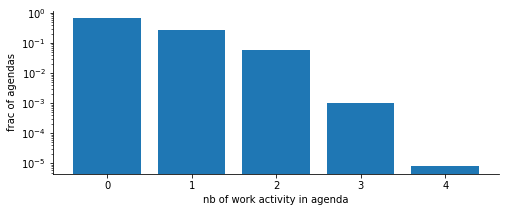

68% of agents don't go to work
94% of agents have 1 work axctivity or less
So for 6% of agents it's useful to store their first workplace and assign it to all their next trips to work


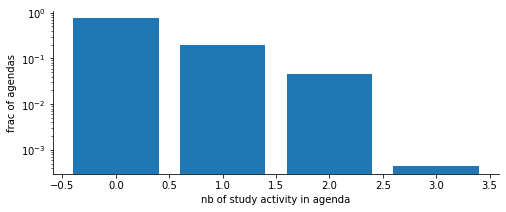

76% of agents don't go study
95% of agents have 1 study activity place or less
So for 5% of agents it's useful to store their first study place and assign it to all their next trips to work


In [9]:
synthpop['nb_work_in_agenda'] = 0
for i in range(1, max_chain_len):
    synthpop['nb_work_in_agenda'] += (synthpop['dep_{}_motif'.format(i)]==1).astype(int)

fig, ax = plt.subplots(figsize=(8,3))
ax.bar(np.arange(len(synthpop['nb_work_in_agenda'].unique())),
    (synthpop.groupby('nb_work_in_agenda').size()/len(synthpop)))
ax.set_xlabel('nb of work activity in agenda')
ax.set_ylabel('frac of agendas')
ax.set_yscale('log')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.show()
print('{:.0f}% of agents don\'t go to work'.format(100*(synthpop['nb_work_in_agenda']==0).sum()/len(synthpop)))
print('{:.0f}% of agents have 1 work activity or less'.format(100*(synthpop['nb_work_in_agenda']<=1).sum()/len(synthpop)))
print('So for {:.0f}% of agents it\'s useful to store their first workplace and assign it to all their next trips to work'.format(100*(synthpop['nb_work_in_agenda']>1).sum()/len(synthpop)))


synthpop['nb_study_in_agenda'] = 0
for i in range(1, max_chain_len):
    synthpop['nb_study_in_agenda'] += (synthpop['dep_{}_motif'.format(i)]==2).astype(int)

fig, ax = plt.subplots(figsize=(8,3))
ax.bar(np.arange(len(synthpop['nb_study_in_agenda'].unique())),
    (synthpop.groupby('nb_study_in_agenda').size()/len(synthpop)))
ax.set_xlabel('nb of study activity in agenda')
ax.set_ylabel('frac of agendas')
ax.set_yscale('log')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.show()

print('{:.0f}% of agents don\'t go study'.format(100*(synthpop['nb_study_in_agenda']==0).sum()/len(synthpop)))
print('{:.0f}% of agents have 1 study activity or less'.format(100*(synthpop['nb_study_in_agenda']<=1).sum()/len(synthpop)))
print('So for {:.0f}% of agents it\'s useful to store their first study place and assign it to all their next trips to work'.format(100*(synthpop['nb_study_in_agenda']>1).sum()/len(synthpop)))

<a id='v2'></a>
## v2: Forward sampling with deterministic home, work, study places
* Consider the first activity is at home (as determined in census)
* For each step of the activity chain, draw a destination from transition matrix conditionnal on origin and time of departure.
* [back to summary](#summary)

In [10]:
# 00:05:00

locations = np.zeros((len(synthpop), max_chain_len+1))
locations[:,0] = synthpop['iris_or_commune']

for irow, row in tqdm(synthpop.iterrows(), total=len(synthpop)):
    chain_len = int(row['chain_len'])
    work_location = None
    study_location = None
    
    for i in range(1, chain_len+1):
        time_col = 'dep_{}_time'.format(i)
        motif_col = 'dep_{}_motif'.format(i)

        if row[motif_col]==0:
            locations[irow, i] = row['iris_or_commune']
        elif row[motif_col]==1 and work_location:
            locations[irow, i] = work_location
        elif row[motif_col]==2 and study_location:
            locations[irow, i] = study_location
        else:
            d_list, proba_d = get_proba_d(locations[irow, i-1], row[time_col])
            locations[irow, i] = np.random.choice(a=d_list, p=proba_d)
            if row[motif_col]==1:
                work_location = locations[irow, i]
            if row[motif_col]==2:
                study_location = locations[irow, i]

synthpop[['dep_{}_zone'.format(i) for i in range(max_chain_len+1)]] = locations
outpath = synthpop_path[:-4] + '_spatializev3.csv'
synthpop.to_csv(outpath, index=False)
print('Saving to {}'.format(outpath))
synthpop.head()

100%|███████████████████████████████| 1376085/1376085 [05:12<00:00, 4407.26it/s]


/Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev3.csv


,iris_or_commune,gender,has_car,occupation,age,home_status,main_transport_work,id_agenda,dep_0_motif,dep_0_zone,...,autonomy,work_tm_in_agenda,work_in_agenda,study_in_agenda,need_commute,transport_mode_commute,L2_dist_commute,agent_id,nb_work_in_agenda,nb_study_in_agenda
0,690270102,0,1,8,3,0,-1,2510031351,0.0,690270102.0,...,2.0,NaN,False,False,False,NaN,NaN,0,0,0
1,690270105,0,1,8,3,0,-1,2510031351,0.0,690270105.0,...,2.0,NaN,False,False,False,NaN,NaN,1,0,0
2,690270105,0,1,8,3,0,-1,2510031351,0.0,690270105.0,...,2.0,NaN,False,False,False,NaN,NaN,2,0,0
3,690430101,0,1,8,3,0,-1,2510031351,0.0,690430101.0,...,2.0,NaN,False,False,False,NaN,NaN,3,0,0
4,690430101,0,1,8,3,0,-1,2510031351,0.0,690430101.0,...,2.0,NaN,False,False,False,NaN,NaN,4,0,0


<a id='v4'></a>
## v4: Forward sampling with deterministic home, linked work and study — conditional on mode
* Consider the first activity is at home (as determined in census)
* For each step of the activity chain, draw a destination from transition matrix conditionnal on origin and time of departure.
* If activity motive is `home`, deterministically assign the home area
* If activity motive is `work`, deterministically assign the work area
* If activity motive is `study`, deterministically assign the study area
* [back to summary](#summary)

In [11]:
# 00:07:00

locations = np.zeros((len(synthpop), max_chain_len+1))
locations[:,0] = synthpop['iris_or_commune']

for irow, row in tqdm(synthpop.iterrows(), total=len(synthpop)):
    chain_len = int(row['chain_len'])
    work_location = None
    study_location = None
    
    for i in range(1, chain_len+1):
        time_col = 'dep_{}_time'.format(i)
        motif_col = 'dep_{}_motif'.format(i)
        mode_col = 'dep_{}_mode'.format(i)
        
        if row[motif_col]==0:
            locations[irow, i] = row['iris_or_commune']
        elif row[motif_col]==1 and work_location:
            locations[irow, i] = work_location
        elif row[motif_col]==2 and study_location:
            locations[irow, i] = study_location
        else:
            d_list, proba_d = get_mode_proba_d(locations[irow, i-1], row[time_col], row[mode_col])
            locations[irow, i] = np.random.choice(a=d_list, p=proba_d)
            if row[motif_col]==1:
                work_location = locations[irow, i]
            if row[motif_col]==2:
                study_location = locations[irow, i]

synthpop[['dep_{}_zone'.format(i) for i in range(max_chain_len+1)]] = locations
out_path = synthpop_path[:-4] + '_spatializev4.csv'
synthpop.to_csv(out_path, index=False)
print('Saving to {}'.format(outpath))
synthpop.head()

100%|███████████████████████████████| 1376085/1376085 [05:15<00:00, 4366.82it/s]


/Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev4.csv


,iris_or_commune,gender,has_car,occupation,age,home_status,main_transport_work,id_agenda,dep_0_motif,dep_0_zone,...,autonomy,work_tm_in_agenda,work_in_agenda,study_in_agenda,need_commute,transport_mode_commute,L2_dist_commute,agent_id,nb_work_in_agenda,nb_study_in_agenda
0,690270102,0,1,8,3,0,-1,2510031351,0.0,690270102.0,...,2.0,NaN,False,False,False,NaN,NaN,0,0,0
1,690270105,0,1,8,3,0,-1,2510031351,0.0,690270105.0,...,2.0,NaN,False,False,False,NaN,NaN,1,0,0
2,690270105,0,1,8,3,0,-1,2510031351,0.0,690270105.0,...,2.0,NaN,False,False,False,NaN,NaN,2,0,0
3,690430101,0,1,8,3,0,-1,2510031351,0.0,690430101.0,...,2.0,NaN,False,False,False,NaN,NaN,3,0,0
4,690430101,0,1,8,3,0,-1,2510031351,0.0,690430101.0,...,2.0,NaN,False,False,False,NaN,NaN,4,0,0


<a id='v4.5'></a>
## v4.5: Forward sampling with deterministic home linked work and study — conditional on distance only
* Consider the first activity is at home (as determined in census)
* For each step of the activity chain, draw a destination from transition matrix conditionnal on origin and time of departure.
* If activity motive is `home`, deterministically assign the home area
* If activity motive is `work`, deterministically assign the work area
* If activity motive is `study`, deterministically assign the study area
* [back to summary](#summary)

In [7]:
transition_matrix_path = '../../outdata/trans_matrix_by_distbin.csv'

c=Chrono('Loading transition matrix...')
trans_matrix_dist = pd.read_csv(transition_matrix_path)
c.write('{} rows'.format(len(trans_matrix_dist)))

c.write('Adding dist_bin column...')

dist_bins = (trans_matrix_dist
 .groupby(['dist_bin_min', 'dist_bin_max']).size().reset_index()
 .apply(lambda r: (r['dist_bin_min'], r['dist_bin_max']), axis=1)
 .values)

c.write('dist bins:')
c.write('{}'.format(dist_bins))
bin_replace_dict = {rmin:i for i, (rmin, rmax) in enumerate(dist_bins)}
trans_matrix_dist['dist_bin'] = trans_matrix_dist['dist_bin_min'].replace(bin_replace_dict)
c.done()
trans_matrix_dist.head()



10:58:52	Loading transition matrix...
00:00:02	3369128 rows
00:00:02	Adding dist_bin column...
00:00:02	dist bins:
00:00:02	[(0.0, 500.0) (500.0, 750.0) (750.0, 1000.0) (1000.0, 3000.0)
 (3000.0, 5000.0) (5000.0, 7000.0) (7000.0, 9000.0) (9000.0, inf)]
00:00:02	Work complete !


,o,d,t,vol,proba_d,dist_bin_min,dist_bin_max,dist_bin
0,1043,1043,0.0,9.132230,1.0,0,500.0,0
1,1043,1043,2.0,5.813602,1.0,0,500.0,0
2,1043,1043,5.0,17.833213,1.0,0,500.0,0
3,1043,1043,7.0,54.360548,1.0,0,500.0,0
4,1043,1043,8.0,29.113536,1.0,0,500.0,0


In [8]:

c.write('To dict...')
dist_d_list_dict = {}
dist_proba_d_dict = {}

for o in tqdm(trans_matrix_dist['o'].unique()):
    trans_matrix_sub_o = trans_matrix_dist[trans_matrix_dist['o']==o]
    for t in timesteps:
        trans_matrix_sub_ot = trans_matrix_sub_o[trans_matrix_sub_o['t']==t]

        for b in range(len(dist_bins)):
            trans_matrix_sub = trans_matrix_sub_ot[trans_matrix_sub_ot['dist_bin']==b]

            k = (o,t,b)
            trans_matrix_sub = trans_matrix_sub.sort_values('d')
            
            dist_d_list_dict[k] = trans_matrix_sub['d'].values
            dist_proba_d_dict[k] = trans_matrix_sub['proba_d'].values

c.done()


00:00:02	To dict...


100%|█████████████████████████████████████████| 536/536 [00:42<00:00, 12.49it/s]

00:00:45	Work complete !


In [9]:

for i in range(1, max_chain_len+1):
    synthpop['dep_{}_dist_bin'.format(i)] = pd.cut(synthpop['dep_{}_l2'.format(i)], 
                                                  bins=[0] + [rmax for rmin, rmax in dist_bins], 
                                                  labels=range(len(dist_bins)),
                                                  include_lowest=True).astype(float)

In [10]:
def get_dist_proba_d(o, t, b):
    """
    return proba of each d given o, t, b
    o: origin
    t: timestep
    b: dist_bin
    
    If no destination exist for this otb, look into the nearest neighbor of o
    iteratively as long as we didn't exhaust the list of nearest neighbors.
    """
    key = (o, t, b)
    d_list = dist_d_list_dict.get(key)
    
    # getting the transitions from nearest zone instead
    if d_list is None or len(d_list)==0:
        z_row = iris_commune[iris_commune['iris_or_commune']==o]
        neighbor_rank = 0
        
        while d_list is None or len(d_list)==0:
            neighbor_col = 'nearest_neighbor_{}'.format(neighbor_rank)
            try:
                nn = z_row[neighbor_col].values.item()
            except:
                raise ValueError('error fetching (o,t,dist_bin) = {}'.format((o, t,dist_bin)))
            key = (nn,t,b)
            d_list = dist_d_list_dict.get(key)
            neighbor_rank += 1
            
    proba_d = dist_proba_d_dict[key]
    return d_list, proba_d

In [11]:
# 00:07:00

locations = np.zeros((len(synthpop), max_chain_len+1))
locations[:,0] = synthpop['iris_or_commune']

for irow, row in tqdm(synthpop.iterrows(), total=len(synthpop)):
    chain_len = int(row['chain_len'])
    work_location = None
    study_location = None
    
    for i in range(1, chain_len+1):
        time_col = 'dep_{}_time'.format(i)
        motif_col = 'dep_{}_motif'.format(i)
        dist_bin_col = 'dep_{}_dist_bin'.format(i)
        
        if row[motif_col]==0:
            locations[irow, i] = row['iris_or_commune']
        elif row[motif_col]==1 and work_location:
            locations[irow, i] = work_location
        elif row[motif_col]==2 and study_location:
            locations[irow, i] = study_location
        else:
            d_list, proba_d = get_dist_proba_d(locations[irow, i-1], row[time_col], row[dist_bin_col])
            locations[irow, i] = np.random.choice(a=d_list, p=proba_d)
            if row[motif_col]==1:
                work_location = locations[irow, i]
            if row[motif_col]==2:
                study_location = locations[irow, i]

synthpop[['dep_{}_zone'.format(i) for i in range(max_chain_len+1)]] = locations
out_path = synthpop_path[:-4] + '_spatializev45.csv'
synthpop.to_csv(out_path, index=False)
print(out_path)
synthpop.head()

100%|███████████████████████████████| 1375987/1375987 [04:11<00:00, 5478.18it/s]


/Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev45.csv


,iris_or_commune,gender,has_car,occupation,age,home_status,main_transport_work,id_agenda,dep_0_motif,dep_0_zone,...,dep_1_dist_bin,dep_2_dist_bin,dep_3_dist_bin,dep_4_dist_bin,dep_5_dist_bin,dep_6_dist_bin,dep_7_dist_bin,dep_8_dist_bin,dep_9_dist_bin,dep_10_dist_bin
0,690270102,0,1,8,3,0,-1,2520011172,0.0,690270102.0,...,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN
1,690270102,0,1,8,3,0,-1,2520011172,0.0,690270102.0,...,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN
2,690270102,0,1,8,3,0,-1,2520011172,0.0,690270102.0,...,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN
3,690270102,0,1,8,3,0,-1,2520011172,0.0,690270102.0,...,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN
4,690270102,0,1,8,3,0,-1,2520011172,0.0,690270102.0,...,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN


<a id='v5'></a>
## v5: Forward sampling with deterministic home linked work and study — conditional on mode and distance
* Consider the first activity is at home (as determined in census)
* For each step of the activity chain, draw a destination from transition matrix conditionnal on origin and time of departure.
* If activity motive is `home`, deterministically assign the home area
* If activity motive is `work`, deterministically assign the work area
* If activity motive is `study`, deterministically assign the study area
* [back to summary](#summary)

In [9]:
transition_matrix_mode_dist_path = '../../outdata/trans_matrix_by_mode_distbin.csv'

c=Chrono('Loading transition matrix...')
trans_matrix_mode_dist = pd.read_csv(transition_matrix_mode_dist_path)
c.write('{} rows'.format(len(trans_matrix_mode_dist)))

c.write('Adding dist_bin column...')

dist_bins = (trans_matrix_mode_dist
 .groupby(['dist_bin_min', 'dist_bin_max']).size().reset_index()
 .apply(lambda r: (r['dist_bin_min'], r['dist_bin_max']), axis=1)
 .values)

c.write('dist bins:')
c.write('{}'.format(dist_bins))
bin_replace_dict = {rmin:i for i, (rmin, rmax) in enumerate(dist_bins)}
trans_matrix_mode_dist['dist_bin'] = trans_matrix_mode_dist['dist_bin_min'].replace(bin_replace_dict)
c.done()
trans_matrix_mode_dist.head()



14:23:39	Loading transition matrix...
00:00:13	12627576 rows
00:00:13	Adding dist_bin column...
00:00:14	dist bins:
00:00:14	[(0.0, 500.0) (500.0, 750.0) (750.0, 1000.0) (1000.0, 3000.0)
 (3000.0, 5000.0) (5000.0, 7000.0) (7000.0, 9000.0) (9000.0, inf)]
00:00:15	Work complete !


,o,d,t,vol,proba_d,mode,dist_bin_min,dist_bin_max,dist_bin
0,1043,1043,0.0,6.109734,1.0,0,0,500.0,0
1,1043,1043,2.0,3.889473,1.0,0,0,500.0,0
2,1043,1043,5.0,11.930950,1.0,0,0,500.0,0
3,1043,1043,7.0,36.368826,1.0,0,0,500.0,0
4,1043,1043,8.0,19.477823,1.0,0,0,500.0,0


In [11]:

c.write('To dict...')
dist_mode_d_list_dict = {}
dist_mode_proba_d_dict = {}

for o in tqdm(trans_matrix_mode_dist['o'].unique()):
    trans_matrix_sub_o = trans_matrix_mode_dist[trans_matrix_mode_dist['o']==o]
    for t in timesteps:
        trans_matrix_sub_ot = trans_matrix_sub_o[trans_matrix_sub_o['t']==t]
        for m in range(4):
            trans_matrix_sub_otm = trans_matrix_sub_ot[trans_matrix_sub_ot['mode']==m]
            for b in range(len(dist_bins)):
                trans_matrix_sub = trans_matrix_sub_otm[trans_matrix_sub_otm['dist_bin']==b]
    
                k = (o,t,m,b)
                trans_matrix_sub = trans_matrix_sub.sort_values('d')
                
                dist_mode_d_list_dict[k] = trans_matrix_sub['d'].values
                dist_mode_proba_d_dict[k] = trans_matrix_sub['proba_d'].values

c.done()


00:02:24	To dict...


100%|█████████████████████████████████████████| 536/536 [03:12<00:00,  2.79it/s]

00:05:36	Work complete !


In [1]:

for i in range(1, max_chain_len+1):
    synthpop['dep_{}_dist_bin'.format(i)] = pd.cut(synthpop['dep_{}_l2'.format(i)], 
                                                  bins=[0] + [rmax for rmin, rmax in dist_bins], 
                                                  labels=range(len(dist_bins)),
                                                  include_lowest=True).astype(float)

NameError: name 'max_chain_len' is not defined

In [12]:
def get_mode_dist_proba_d(o, t, m, b):
    """
    return proba of each d given o, t, m
    o: origin
    t: timestep
    m: transport mode
    b: dist_bin
    
    If no destination exist for this otm, look into the nearest neighbor of o
    iteratively as long as we didn't exhaust the list of nearest neighbors.
    """
    key = (o, t, m, b)
    d_list = dist_mode_d_list_dict.get(key)
    
    # getting the transitions from nearest zone instead
    if d_list is None or len(d_list)==0:
        z_row = iris_commune[iris_commune['iris_or_commune']==o]
        neighbor_rank = 0
        
        while d_list is None or len(d_list)==0:
            neighbor_col = 'nearest_neighbor_{}'.format(neighbor_rank)
            try:
                nn = z_row[neighbor_col].values.item()
            except:
                raise ValueError('error fetching (o,t,m,dist_bin) = {}'.format((o, t,m,dist_bin)))
            key = (nn,t,m,b)
            d_list = dist_mode_d_list_dict.get(key)
            neighbor_rank += 1
            
    proba_d = dist_mode_proba_d_dict[key]
    return d_list, proba_d

In [17]:
# 00:07:00

locations = np.zeros((len(synthpop), max_chain_len+1))
locations[:,0] = synthpop['iris_or_commune']

for irow, row in tqdm(synthpop.iterrows(), total=len(synthpop)):
    chain_len = int(row['chain_len'])
    work_location = None
    study_location = None
    
    for i in range(1, chain_len+1):
        time_col = 'dep_{}_time'.format(i)
        motif_col = 'dep_{}_motif'.format(i)
        mode_col = 'dep_{}_mode'.format(i)
        dist_bin_col = 'dep_{}_dist_bin'.format(i)
        
        if row[motif_col]==0:
            locations[irow, i] = row['iris_or_commune']
        elif row[motif_col]==1 and work_location:
            locations[irow, i] = work_location
        elif row[motif_col]==2 and study_location:
            locations[irow, i] = study_location
        else:
            d_list, proba_d = get_mode_dist_proba_d(locations[irow, i-1], row[time_col],
                                                    row[mode_col], row[dist_bin_col])
            locations[irow, i] = np.random.choice(a=d_list, p=proba_d)
            if row[motif_col]==1:
                work_location = locations[irow, i]
            if row[motif_col]==2:
                study_location = locations[irow, i]

synthpop[['dep_{}_zone'.format(i) for i in range(max_chain_len+1)]] = locations
out_path = synthpop_path[:-4] + '_spatializev5.csv'
synthpop.to_csv(out_path, index=False)
print(out_path)
synthpop.head()

100%|███████████████████████████████| 1376355/1376355 [05:15<00:00, 4363.11it/s]


/Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev5.csv


,iris_or_commune,gender,has_car,occupation,age,home_status,main_transport_work,id_agenda,dep_0_motif,dep_0_zone,...,dep_1_dist_bin,dep_2_dist_bin,dep_3_dist_bin,dep_4_dist_bin,dep_5_dist_bin,dep_6_dist_bin,dep_7_dist_bin,dep_8_dist_bin,dep_9_dist_bin,dep_10_dist_bin
0,690270102,0,1,8,3,0,-1,2520011172,0.0,690270102.0,...,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN
1,690270102,0,1,8,3,0,-1,2520011172,0.0,690270102.0,...,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN
2,690270102,0,1,8,3,0,-1,2520011172,0.0,690270102.0,...,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN
3,690270102,0,1,8,3,0,-1,2520011172,0.0,690270102.0,...,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN
4,690270102,0,1,8,3,0,-1,2520011172,0.0,690270102.0,...,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN


<a id='end'></a>

* [back to summary](#summary)